In [10]:
"""
Streamlined Data Processing Pipeline for Retail Store Analytics
Optimized for efficiency while maintaining core functionality.
"""

import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
import logging
import warnings

from pandas.errors import DtypeWarning

warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings('ignore', category=DtypeWarning)


class DataProcessor:
    """Streamlined data processing pipeline for retail analytics."""
    
    def __init__(self, data_dir: str = '../data', log_level: str = 'INFO'):
        self.data_dir = Path(data_dir)
        self.logger = self._setup_logging(log_level)
        self.quality_report = {}
        
    def _setup_logging(self, level: str) -> logging.Logger:
        """Setup basic logging."""
        logger = logging.getLogger('DataProcessor')
        logger.setLevel(getattr(logging, level.upper()))
        
        if not logger.handlers:
            handler = logging.StreamHandler()
            formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
            handler.setFormatter(formatter)
            logger.addHandler(handler)
        return logger
    
    def load_and_merge(self, train_file: str = 'train.csv', store_file: str = 'store.csv') -> pd.DataFrame:
        """Load and merge training and store data."""
        self.logger.info("Loading and merging datasets")
        train_df = pd.read_csv(self.data_dir / train_file, low_memory=False)
        store_df = pd.read_csv(self.data_dir / store_file)
        if train_df.empty or store_df.empty:
            raise ValueError("One or both datasets are empty")
        merged_df = pd.merge(train_df, store_df, on='Store', how='left')
        self.logger.info(f"Merged datasets: {merged_df.shape}")
        return merged_df
    
    def clean_and_engineer(self, df: pd.DataFrame) -> pd.DataFrame:
        """Clean data and engineer features in one step."""
        self.logger.info("Cleaning data and engineering features")
        
        # Store quality metrics
        self.quality_report = {
            'original_shape': df.shape,
            'missing_before': df.isnull().sum().sum()
        }
        
        # Convert date and handle missing values
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df['Open'].fillna(1, inplace=True)
        
        # Fill object columns with 'Unknown', numeric columns with median (except 'Open')
        for col in df.columns:
            if df[col].dtype == 'O':
                df[col].fillna('Unknown', inplace=True)
            elif pd.api.types.is_numeric_dtype(df[col]) and col != 'Open':
                df[col].fillna(df[col].median(), inplace=True)
        
        # Optimize data types
        if 'Open' in df.columns:
            df['Open'] = df['Open'].astype(bool)
        
        # Create features efficiently
        df = self._create_features(df)
        
        # Update quality report
        self.quality_report.update({
            'final_shape': df.shape,
            'missing_after': df.isnull().sum().sum()
        })
        
        self.logger.info("Data processing completed")
        return df
    
    def _create_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Create essential features."""
        # Time features
        df['Year'] = df['Date'].dt.year
        df['Month'] = df['Date'].dt.month
        df['Day'] = df['Date'].dt.day
        df['DayOfWeek'] = df['Date'].dt.dayofweek
        df['Quarter'] = df['Date'].dt.quarter
        df['IsWeekend'] = df['DayOfWeek'].isin([5, 6])
        
        # Business features
        if 'Sales' in df.columns and 'Customers' in df.columns:
            df['SalesPerCustomer'] = df['Sales'] / df['Customers'].replace(0, 1)
            df['SalesPerCustomer'] = df['SalesPerCustomer'].replace([np.inf, -np.inf], 0)
        
        if 'CompetitionDistance' in df.columns:
            df['HasNearbyCompetition'] = df['CompetitionDistance'] <= 1000
            df['CompetitionDistance'].fillna(df['CompetitionDistance'].median(), inplace=True)
        
        return df
    
    def save_data(self, df: pd.DataFrame, filename: str = 'cleaned_data.csv') -> Path:
        """Save processed data."""
        self.data_dir.mkdir(parents=True, exist_ok=True)
        output_path = self.data_dir / filename
        
        df.to_csv(output_path, index=False)
        self.logger.info(f"Saved {len(df):,} records to {output_path}")
        
        return output_path
    
    def process(self, train_file: str = 'train.csv', store_file: str = 'store.csv', 
                output_file: str = 'cleaned_data.csv') -> pd.DataFrame:
        """Execute complete processing pipeline."""
        self.logger.info("Starting data processing pipeline")
        
        # Load and merge
        df = self.load_and_merge(train_file, store_file)
        
        # Clean and engineer features
        df = self.clean_and_engineer(df)
        
        # Save results
        self.save_data(df, output_file)
        
        self.logger.info("Pipeline completed successfully")
        return df


def main():
    """Execute the pipeline."""
    processor = DataProcessor()
    
    try:
        data = processor.process()
        
        print("\n" + "="*40)
        print("PROCESSING COMPLETE")
        print("="*40)
        print(f"Shape: {data.shape}")
        print(f"Columns: {len(data.columns)}")
        print("\nSample data:")
        print(data.head())
        
    except Exception as e:
        print(f"Processing failed: {e}")


if __name__ == "__main__":
    main()

2025-07-05 10:53:10,553 - INFO - Starting data processing pipeline
2025-07-05 10:53:10,558 - INFO - Loading and merging datasets
2025-07-05 10:53:10,558 - INFO - Loading and merging datasets
2025-07-05 10:53:10,558 - INFO - Loading and merging datasets
2025-07-05 10:53:10,558 - INFO - Loading and merging datasets
2025-07-05 10:53:10,558 - INFO - Loading and merging datasets
2025-07-05 10:53:10,558 - INFO - Loading and merging datasets
2025-07-05 10:53:10,558 - INFO - Loading and merging datasets
2025-07-05 10:53:11,757 - INFO - Merged datasets: (1017209, 18)
2025-07-05 10:53:11,770 - INFO - Cleaning data and engineering features
2025-07-05 10:53:11,757 - INFO - Merged datasets: (1017209, 18)
2025-07-05 10:53:11,770 - INFO - Cleaning data and engineering features
2025-07-05 10:53:11,757 - INFO - Merged datasets: (1017209, 18)
2025-07-05 10:53:11,770 - INFO - Cleaning data and engineering features
2025-07-05 10:53:11,757 - INFO - Merged datasets: (1017209, 18)
2025-07-05 10:53:11,770 - I


PROCESSING COMPLETE
Shape: (1017209, 25)
Columns: 25

Sample data:
   Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          4 2015-07-31   5263        555  True      1            0   
1      2          4 2015-07-31   6064        625  True      1            0   
2      3          4 2015-07-31   8314        821  True      1            0   
3      4          4 2015-07-31  13995       1498  True      1            0   
4      5          4 2015-07-31   4822        559  True      1            0   

   SchoolHoliday StoreType  ... Promo2SinceWeek  Promo2SinceYear  \
0              1         c  ...            22.0           2012.0   
1              1         a  ...            13.0           2010.0   
2              1         a  ...            14.0           2011.0   
3              1         c  ...            22.0           2012.0   
4              1         a  ...            22.0           2012.0   

     PromoInterval  Year  Month  Day  Quarter IsWeeken

📊 Retail Sales Forecasting - EDA for Indian Market
🔄 Loading data...
✅ Data loaded successfully! Shape: (1017209, 25)

📋 Data Overview:
Date range: 2013-01-01 to 2015-07-31
Number of stores: 1115
Total records: 1017209
Columns: ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day', 'Quarter', 'IsWeekend', 'SalesPerCustomer', 'HasNearbyCompetition']

📈 Sales Statistics:
Average daily sales: ₹5,773.82
Median daily sales: ₹5,744.00
Total sales: ₹5,873,180,623.00
Sales standard deviation: ₹3,849.93

🔍 1. Sales Distribution Analysis


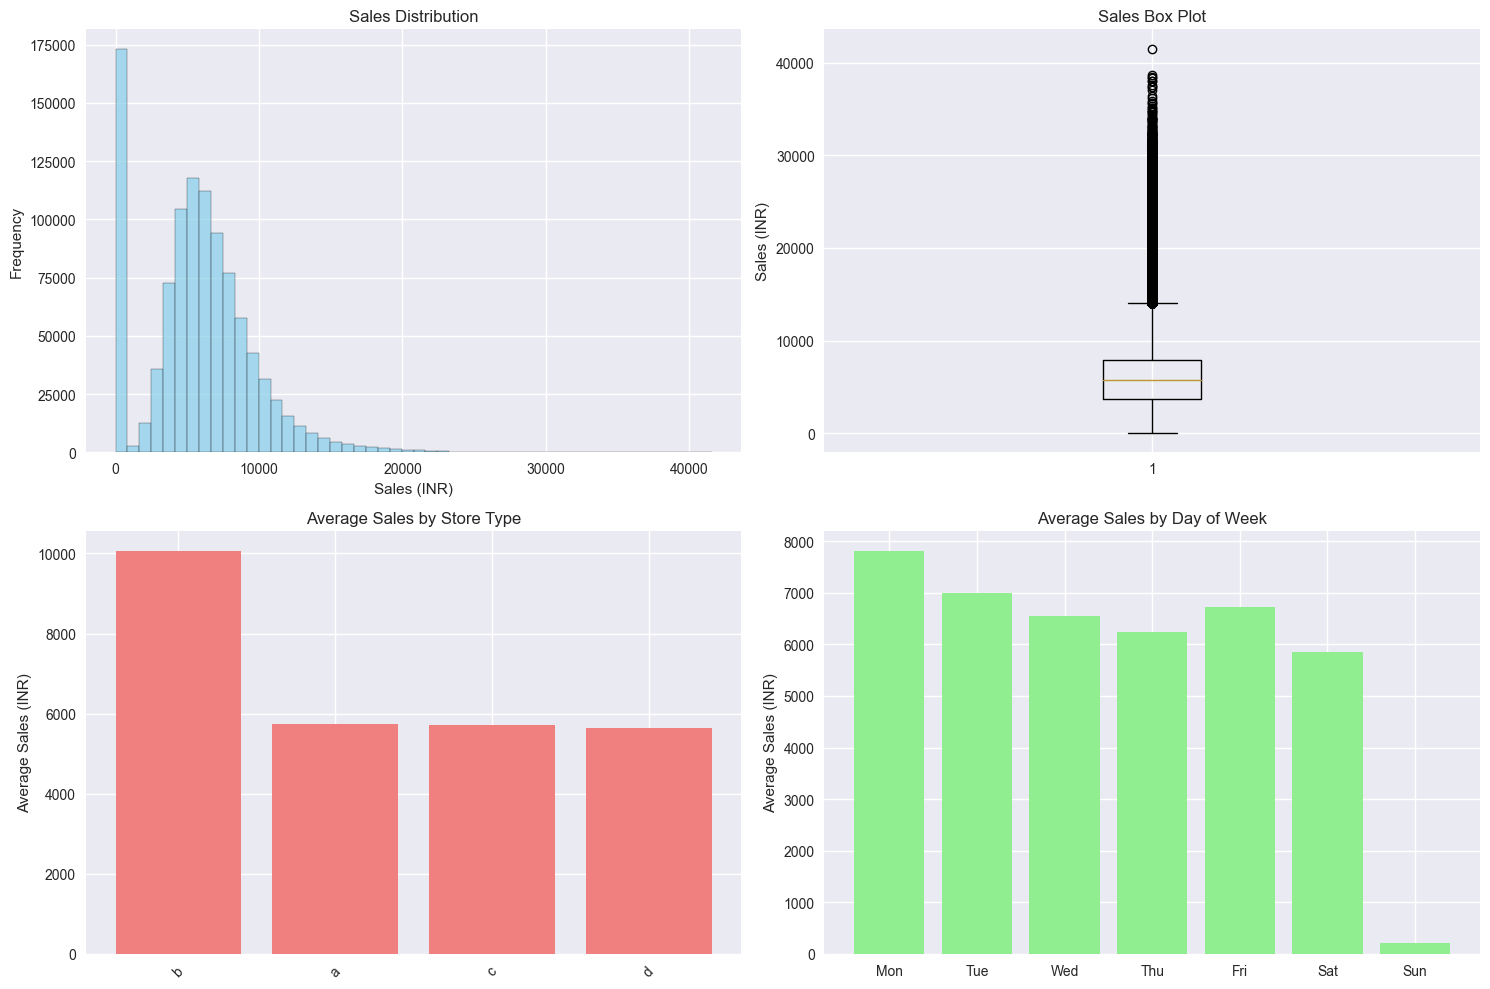


📅 2. Temporal Analysis


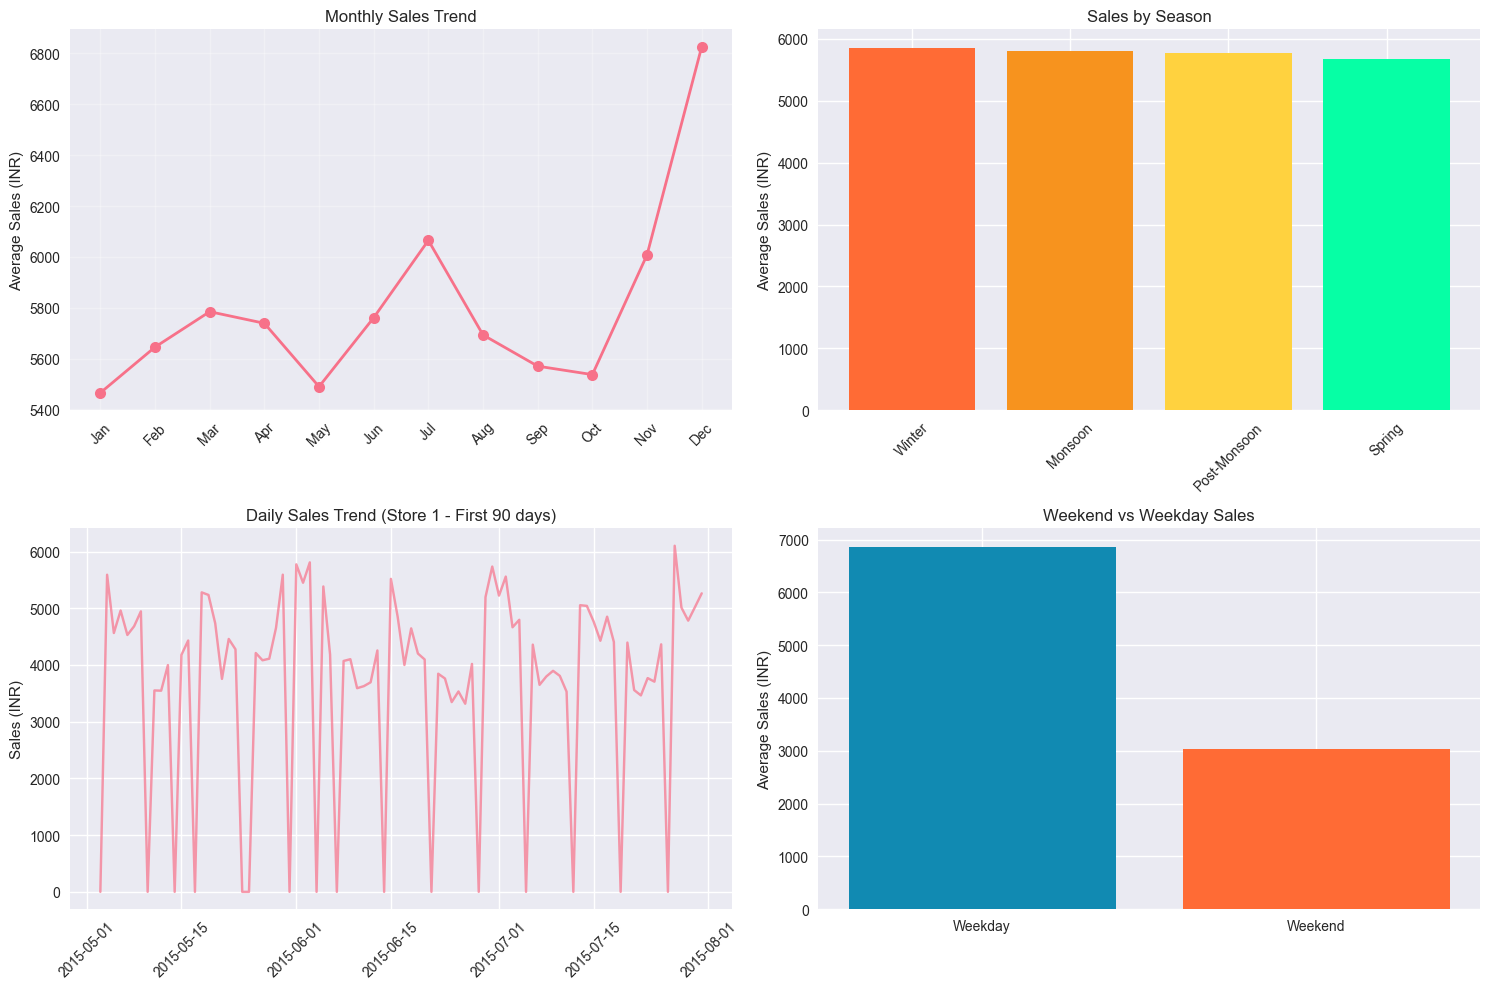


🎊 3. Festival Season Analysis


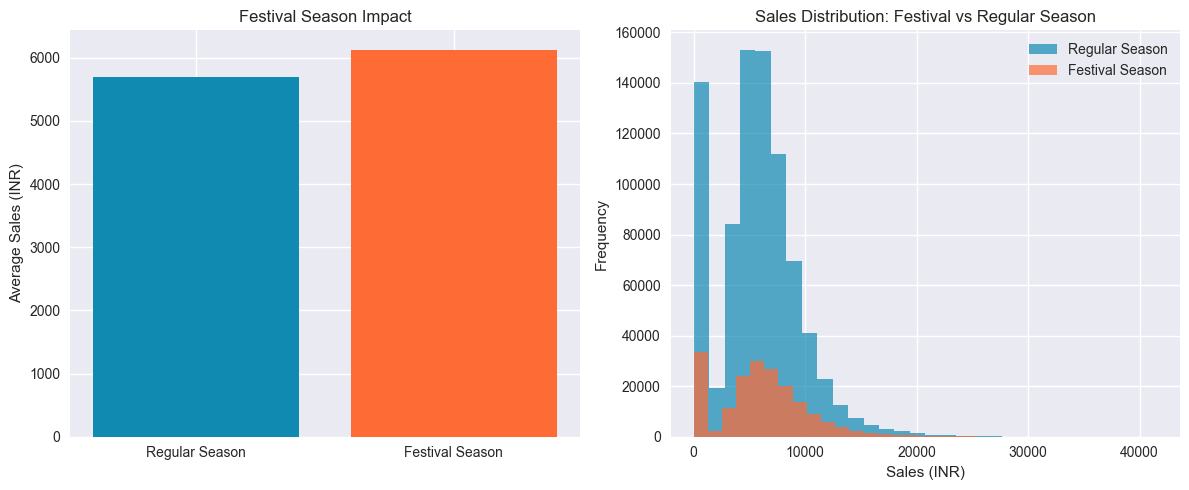


🏪 4. Store Performance Analysis


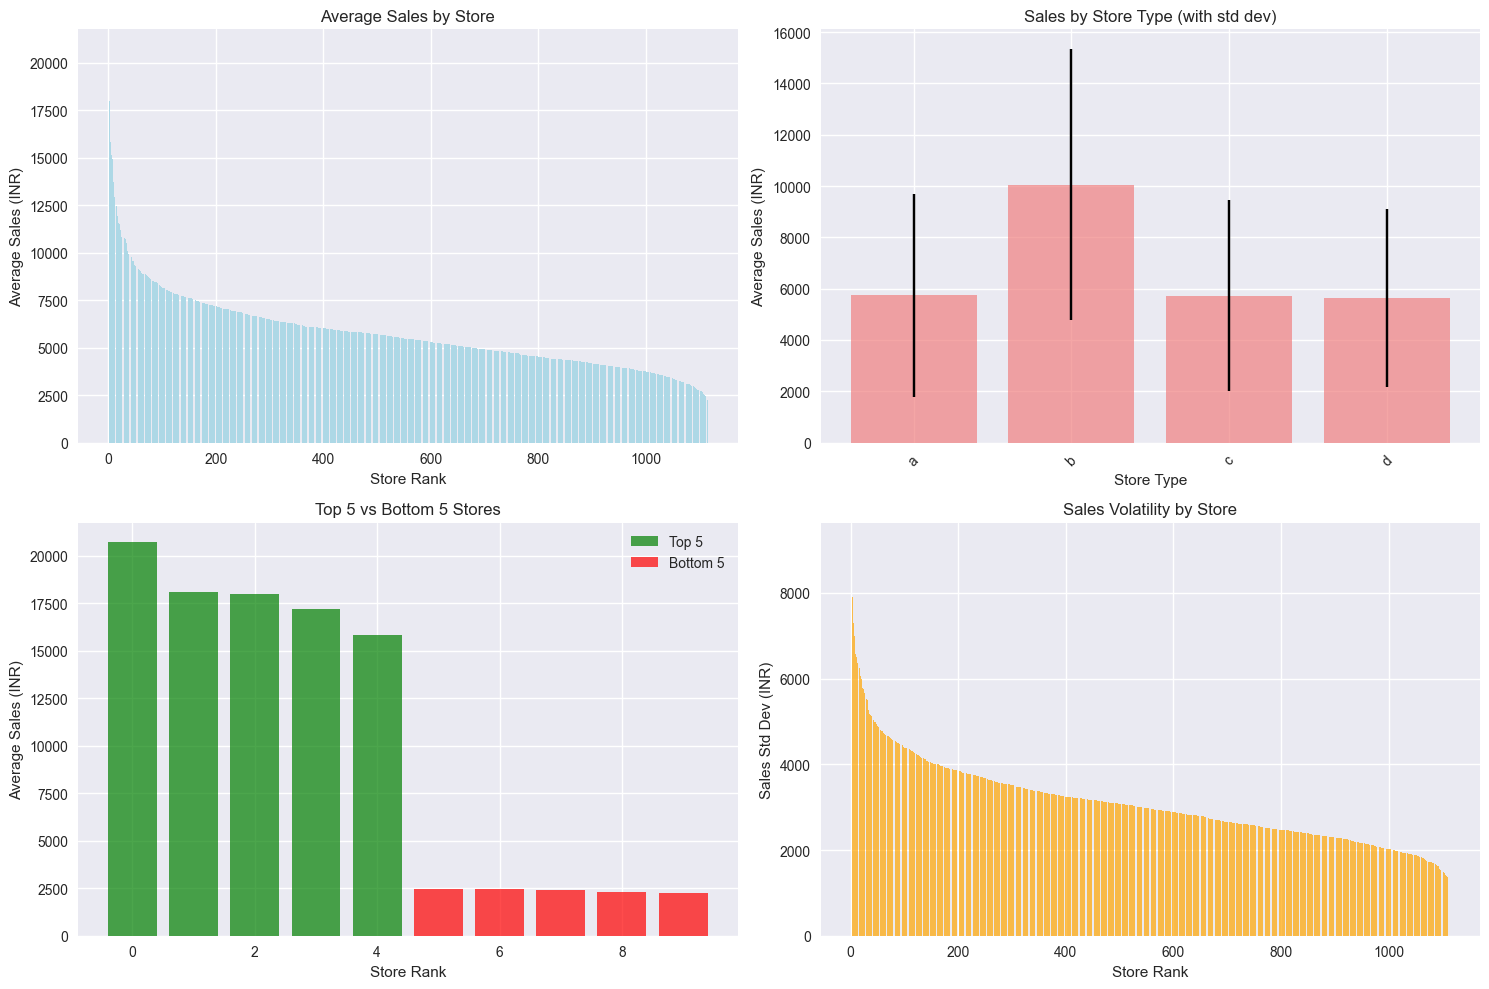


🔗 5. Correlation Analysis


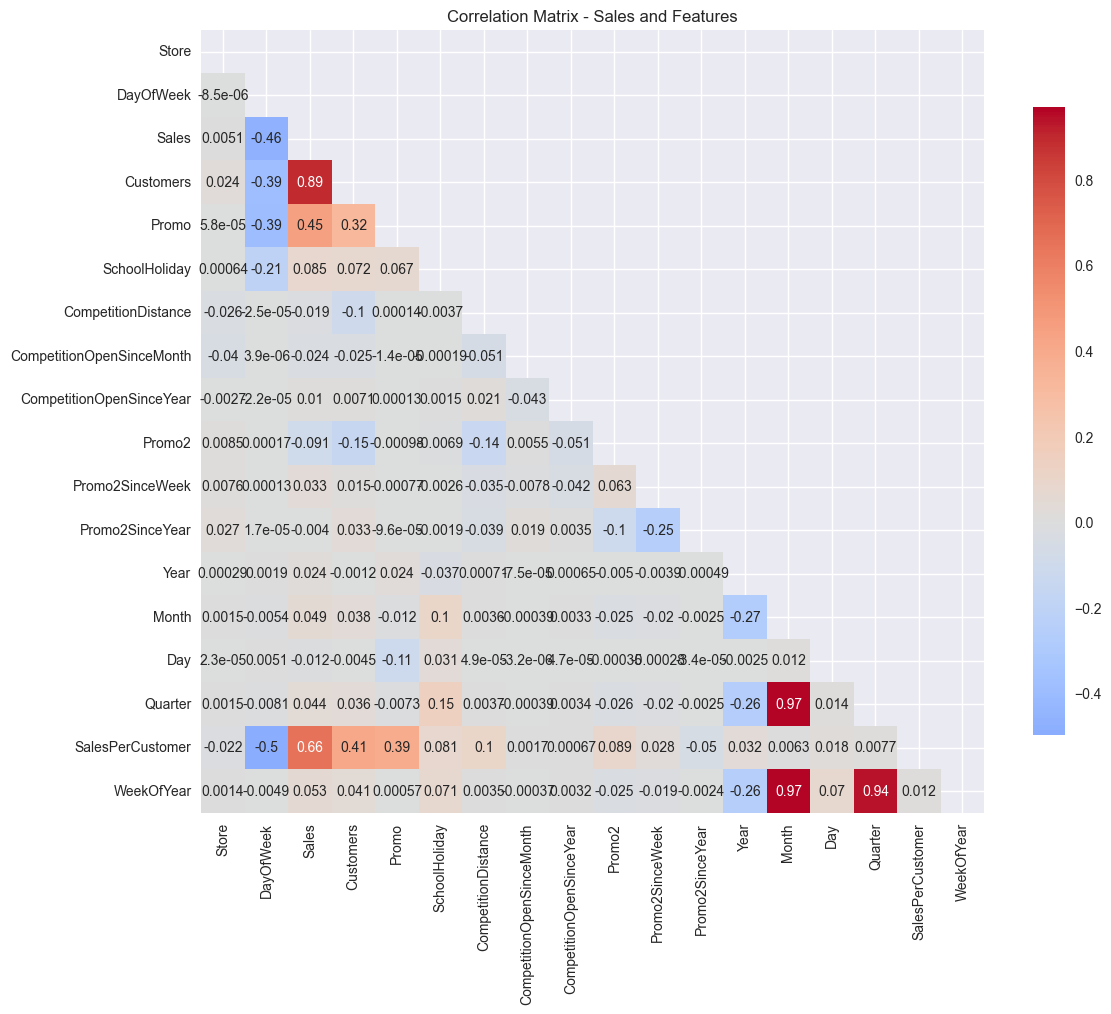


🎯 6. Promotion Impact Analysis


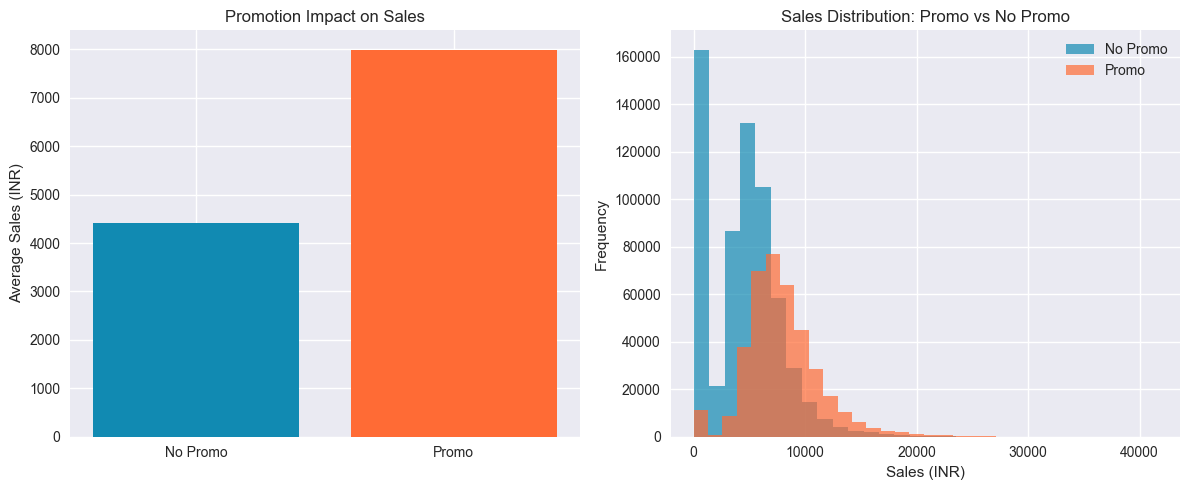

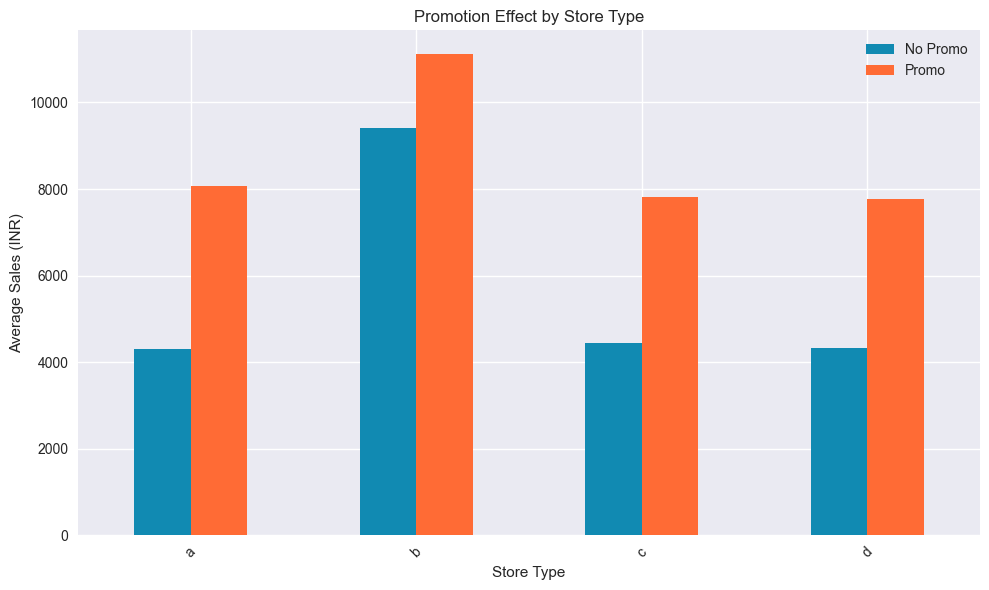


🎄 7. Holiday Impact Analysis


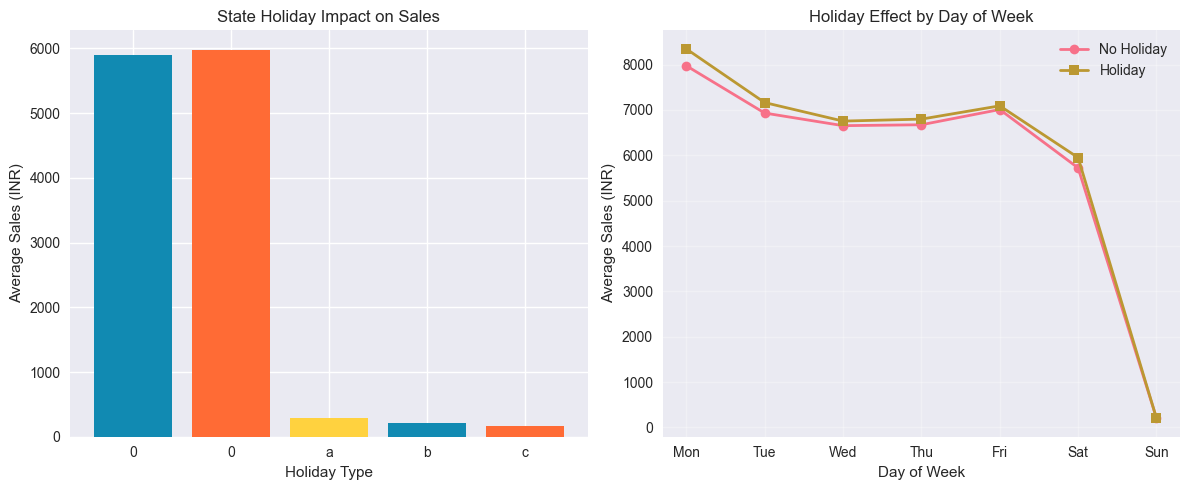


🔍 8. Outlier Detection


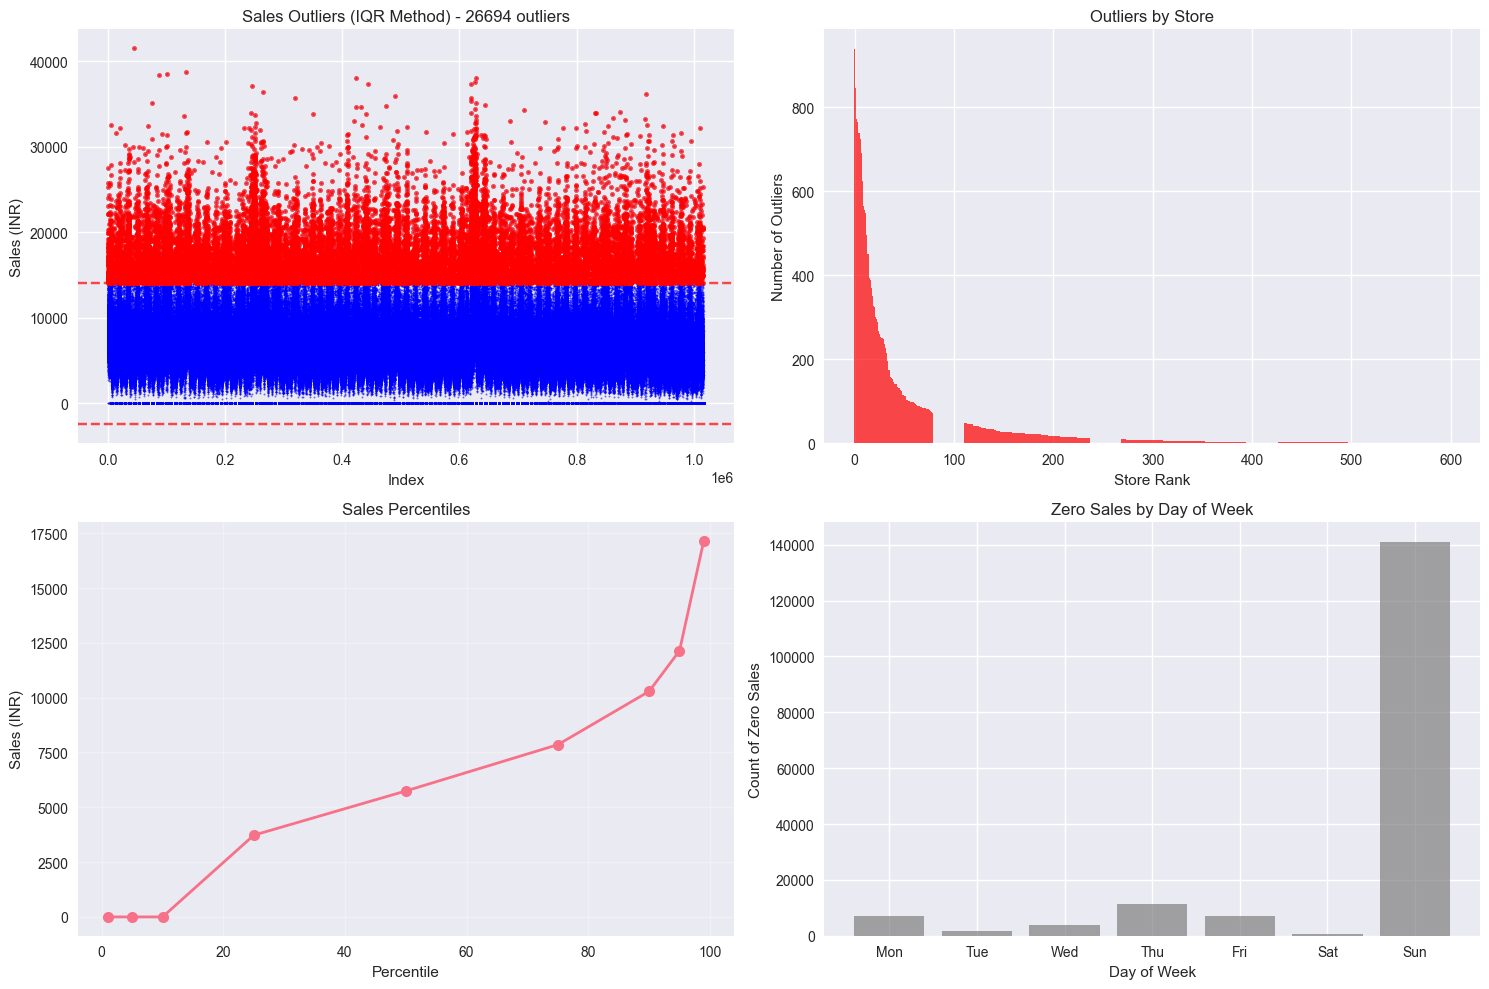


🔧 9. Feature Engineering Insights


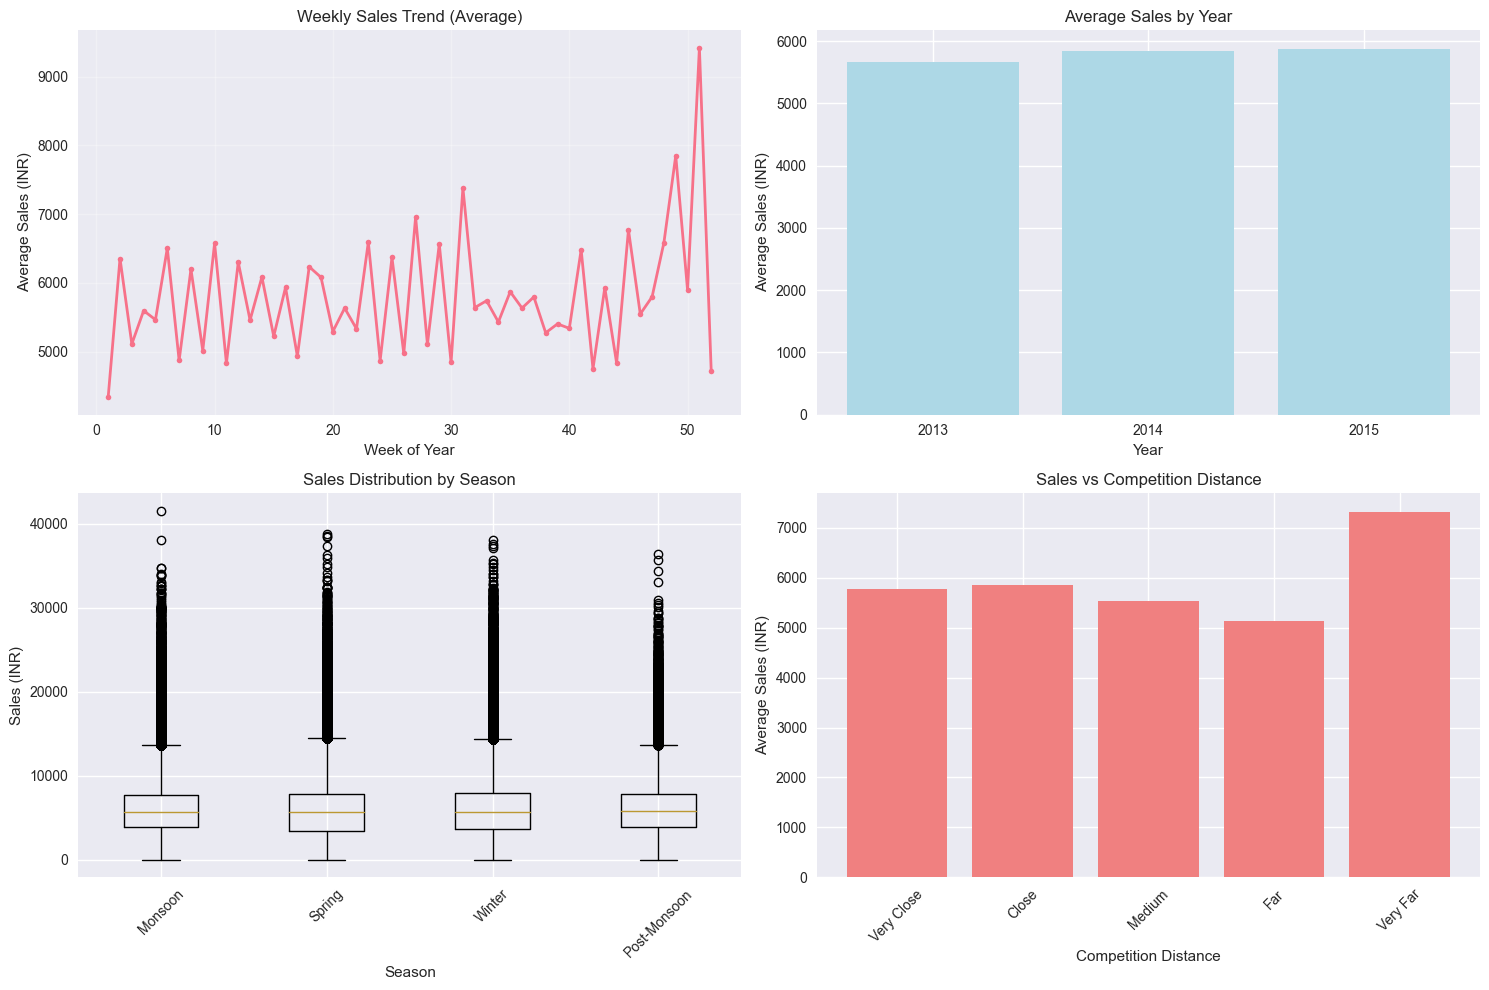


📊 10. Summary Statistics and Key Insights
📈 Key Performance Metrics:
• Total Sales: ₹5,873,180,623.00
• Average Daily Sales: ₹5,773.82
• Peak Sales Day: ₹41,551.00
• Sales Coefficient of Variation: 66.7%

🏆 Best Performing Periods:
• Best Month: Dec (₹6,826.61)
• Best Season: Winter (₹5,861.52)
• Best Day: Mon (₹7,809.04)

🏪 Store Performance:
• Top Performing Store: Store 262 (₹20,718.52)
• Most Volatile Store: Store 817 (σ = ₹9,183.54)
• Performance Range: ₹2,244.50 - ₹20,718.52

🎯 Promotion Impact:
• Promo Sales Lift: 81.4%
• Promo Days: 388,080 out of 1,017,209 (38.2%)

🎊 Festival Season Impact:
• Festival Sales Lift: 7.6%
• Festival Period: Oct-Dec (188,600 days)

📅 Weekend Impact:
• Weekend Sales Lift: -55.9%

🔍 Data Quality:
• Missing Values: 0
• Duplicate Records: 0
• Zero Sales Days: 172871
• Outliers (IQR method): 26694 (2.6%)

✅ EDA Complete! Ready for modeling phase.


In [1]:
# Retail Sales Forecasting - Exploratory Data Analysis
# Indian Market Analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("📊 Retail Sales Forecasting - EDA for Indian Market")
print("=" * 50)

# Load Data
print("🔄 Loading data...")
try:
    df = pd.read_csv('../data/cleaned_data.csv')
    print(f"✅ Data loaded successfully! Shape: {df.shape}")
except FileNotFoundError:
    print("❌ Data file not found. Please run model.py first to generate sample data.")
    exit()

# Data Overview
print("\n📋 Data Overview:")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Number of stores: {df['Store'].nunique()}")
print(f"Total records: {len(df)}")
print(f"Columns: {list(df.columns)}")

# Basic Statistics
print("\n📈 Sales Statistics:")
print(f"Average daily sales: ₹{df['Sales'].mean():,.2f}")
print(f"Median daily sales: ₹{df['Sales'].median():,.2f}")
print(f"Total sales: ₹{df['Sales'].sum():,.2f}")
print(f"Sales standard deviation: ₹{df['Sales'].std():,.2f}")

# Convert date column
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['WeekOfYear'] = df['Date'].dt.isocalendar().week

# Add Indian-specific features
df['Season'] = df['Month'].map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Monsoon', 7: 'Monsoon', 8: 'Monsoon', 9: 'Monsoon',
    10: 'Post-Monsoon', 11: 'Post-Monsoon'
})

df['IsFestivalSeason'] = df['Month'].isin([10, 11, 12])
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6])

# 1. Sales Distribution Analysis
print("\n🔍 1. Sales Distribution Analysis")
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histogram
axes[0, 0].hist(df['Sales'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Sales Distribution')
axes[0, 0].set_xlabel('Sales (INR)')
axes[0, 0].set_ylabel('Frequency')

# Box plot
axes[0, 1].boxplot(df['Sales'])
axes[0, 1].set_title('Sales Box Plot')
axes[0, 1].set_ylabel('Sales (INR)')

# Sales by Store Type
if 'StoreType' in df.columns:
    store_sales = df.groupby('StoreType')['Sales'].mean().sort_values(ascending=False)
    axes[1, 0].bar(store_sales.index, store_sales.values, color='lightcoral')
    axes[1, 0].set_title('Average Sales by Store Type')
    axes[1, 0].set_ylabel('Average Sales (INR)')
    axes[1, 0].tick_params(axis='x', rotation=45)

# Sales by Day of Week
dow_sales = df.groupby('DayOfWeek')['Sales'].mean()
dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1, 1].bar(dow_names, dow_sales.values, color='lightgreen')
axes[1, 1].set_title('Average Sales by Day of Week')
axes[1, 1].set_ylabel('Average Sales (INR)')

plt.tight_layout()
plt.show()

# 2. Temporal Analysis
print("\n📅 2. Temporal Analysis")
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Monthly Sales Trend
monthly_sales = df.groupby('Month')['Sales'].mean()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[0, 0].plot(month_names, monthly_sales.values, marker='o', linewidth=2, markersize=8)
axes[0, 0].set_title('Monthly Sales Trend')
axes[0, 0].set_ylabel('Average Sales (INR)')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# Seasonal Sales
seasonal_sales = df.groupby('Season')['Sales'].mean().sort_values(ascending=False)
axes[0, 1].bar(seasonal_sales.index, seasonal_sales.values, 
               color=['#FF6B35', '#F7931E', '#FFD23F', '#06FFA5'])
axes[0, 1].set_title('Sales by Season')
axes[0, 1].set_ylabel('Average Sales (INR)')
axes[0, 1].tick_params(axis='x', rotation=45)

# Daily Sales Trend (Sample)
daily_sample = df[df['Store'] == 1].head(90)  # First 90 days of Store 1
axes[1, 0].plot(daily_sample['Date'], daily_sample['Sales'], alpha=0.7)
axes[1, 0].set_title('Daily Sales Trend (Store 1 - First 90 days)')
axes[1, 0].set_ylabel('Sales (INR)')
axes[1, 0].tick_params(axis='x', rotation=45)

# Weekend vs Weekday
weekend_comparison = df.groupby('IsWeekend')['Sales'].mean()
axes[1, 1].bar(['Weekday', 'Weekend'], weekend_comparison.values, 
               color=['#118AB2', '#FF6B35'])
axes[1, 1].set_title('Weekend vs Weekday Sales')
axes[1, 1].set_ylabel('Average Sales (INR)')

plt.tight_layout()
plt.show()

# 3. Festival Season Analysis
print("\n🎊 3. Festival Season Analysis")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Festival vs Non-Festival Sales
festival_comparison = df.groupby('IsFestivalSeason')['Sales'].mean()
axes[0].bar(['Regular Season', 'Festival Season'], festival_comparison.values,
            color=['#118AB2', '#FF6B35'])
axes[0].set_title('Festival Season Impact')
axes[0].set_ylabel('Average Sales (INR)')

# Festival season sales distribution
festival_sales = df[df['IsFestivalSeason']]['Sales']
regular_sales = df[~df['IsFestivalSeason']]['Sales']

axes[1].hist(regular_sales, bins=30, alpha=0.7, label='Regular Season', color='#118AB2')
axes[1].hist(festival_sales, bins=30, alpha=0.7, label='Festival Season', color='#FF6B35')
axes[1].set_title('Sales Distribution: Festival vs Regular Season')
axes[1].set_xlabel('Sales (INR)')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.show()

# 4. Store Performance Analysis
print("\n🏪 4. Store Performance Analysis")
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Sales by Store
store_sales = df.groupby('Store')['Sales'].mean().sort_values(ascending=False)
axes[0, 0].bar(range(len(store_sales)), store_sales.values, color='lightblue')
axes[0, 0].set_title('Average Sales by Store')
axes[0, 0].set_xlabel('Store Rank')
axes[0, 0].set_ylabel('Average Sales (INR)')

# Store Type Analysis
if 'StoreType' in df.columns:
    store_type_sales = df.groupby('StoreType')['Sales'].agg(['mean', 'std']).reset_index()
    x_pos = np.arange(len(store_type_sales))
    axes[0, 1].bar(x_pos, store_type_sales['mean'], yerr=store_type_sales['std'], 
                   capsize=5, color='lightcoral', alpha=0.7)
    axes[0, 1].set_title('Sales by Store Type (with std dev)')
    axes[0, 1].set_xlabel('Store Type')
    axes[0, 1].set_ylabel('Average Sales (INR)')
    axes[0, 1].set_xticks(x_pos)
    axes[0, 1].set_xticklabels(store_type_sales['StoreType'], rotation=45)

# Top 5 vs Bottom 5 stores
top_stores = store_sales.head(5)
bottom_stores = store_sales.tail(5)

axes[1, 0].bar(range(5), top_stores.values, color='green', alpha=0.7, label='Top 5')
axes[1, 0].bar(range(5, 10), bottom_stores.values, color='red', alpha=0.7, label='Bottom 5')
axes[1, 0].set_title('Top 5 vs Bottom 5 Stores')
axes[1, 0].set_xlabel('Store Rank')
axes[1, 0].set_ylabel('Average Sales (INR)')
axes[1, 0].legend()

# Sales volatility by store
store_volatility = df.groupby('Store')['Sales'].std().sort_values(ascending=False)
axes[1, 1].bar(range(len(store_volatility)), store_volatility.values, color='orange', alpha=0.7)
axes[1, 1].set_title('Sales Volatility by Store')
axes[1, 1].set_xlabel('Store Rank')
axes[1, 1].set_ylabel('Sales Std Dev (INR)')

plt.tight_layout()
plt.show()

# 5. Correlation Analysis
print("\n🔗 5. Correlation Analysis")
# Select numerical columns for correlation
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()

# Create correlation heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, mask=mask, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix - Sales and Features')
plt.tight_layout()
plt.show()

# 6. Promo Impact Analysis
print("\n🎯 6. Promotion Impact Analysis")
if 'Promo' in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Promo vs No Promo Sales
    promo_comparison = df.groupby('Promo')['Sales'].mean()
    axes[0].bar(['No Promo', 'Promo'], promo_comparison.values, 
                color=['#118AB2', '#FF6B35'])
    axes[0].set_title('Promotion Impact on Sales')
    axes[0].set_ylabel('Average Sales (INR)')
    
    # Sales distribution during promo vs no promo
    promo_sales = df[df['Promo'] == 1]['Sales']
    no_promo_sales = df[df['Promo'] == 0]['Sales']
    
    axes[1].hist(no_promo_sales, bins=30, alpha=0.7, label='No Promo', color='#118AB2')
    axes[1].hist(promo_sales, bins=30, alpha=0.7, label='Promo', color='#FF6B35')
    axes[1].set_title('Sales Distribution: Promo vs No Promo')
    axes[1].set_xlabel('Sales (INR)')
    axes[1].set_ylabel('Frequency')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Promo effect by store type
    if 'StoreType' in df.columns:
        plt.figure(figsize=(10, 6))
        promo_by_store = df.groupby(['StoreType', 'Promo'])['Sales'].mean().unstack()
        promo_by_store.plot(kind='bar', ax=plt.gca(), color=['#118AB2', '#FF6B35'])
        plt.title('Promotion Effect by Store Type')
        plt.xlabel('Store Type')
        plt.ylabel('Average Sales (INR)')
        plt.legend(['No Promo', 'Promo'])
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# 7. Holiday Impact Analysis
print("\n🎄 7. Holiday Impact Analysis")
if 'StateHoliday' in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Holiday vs Non-Holiday Sales
    holiday_comparison = df.groupby('StateHoliday')['Sales'].mean()
    axes[0].bar(range(len(holiday_comparison)), holiday_comparison.values, 
                color=['#118AB2', '#FF6B35', '#FFD23F'])
    axes[0].set_title('State Holiday Impact on Sales')
    axes[0].set_xlabel('Holiday Type')
    axes[0].set_ylabel('Average Sales (INR)')
    axes[0].set_xticks(range(len(holiday_comparison)))
    axes[0].set_xticklabels(holiday_comparison.index)
    
    # Holiday effect by day of week
    holiday_dow = df.groupby(['DayOfWeek', 'StateHoliday'])['Sales'].mean().unstack()
    axes[1].plot(dow_names, holiday_dow.iloc[:, 0], marker='o', label='No Holiday', linewidth=2)
    if holiday_dow.shape[1] > 1:
        axes[1].plot(dow_names, holiday_dow.iloc[:, 1], marker='s', label='Holiday', linewidth=2)
    axes[1].set_title('Holiday Effect by Day of Week')
    axes[1].set_xlabel('Day of Week')
    axes[1].set_ylabel('Average Sales (INR)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 8. Outlier Analysis
print("\n🔍 8. Outlier Detection")
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Sales outliers by IQR method
Q1 = df['Sales'].quantile(0.25)
Q3 = df['Sales'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df[(df['Sales'] < lower_bound) | (df['Sales'] > upper_bound)]

axes[0, 0].scatter(df.index, df['Sales'], alpha=0.5, color='blue', s=1)
axes[0, 0].scatter(outliers.index, outliers['Sales'], color='red', s=10, alpha=0.7)
axes[0, 0].axhline(y=upper_bound, color='red', linestyle='--', alpha=0.7)
axes[0, 0].axhline(y=lower_bound, color='red', linestyle='--', alpha=0.7)
axes[0, 0].set_title(f'Sales Outliers (IQR Method) - {len(outliers)} outliers')
axes[0, 0].set_xlabel('Index')
axes[0, 0].set_ylabel('Sales (INR)')

# Outliers by store
outlier_by_store = outliers.groupby('Store').size().sort_values(ascending=False)
axes[0, 1].bar(range(len(outlier_by_store)), outlier_by_store.values, color='red', alpha=0.7)
axes[0, 1].set_title('Outliers by Store')
axes[0, 1].set_xlabel('Store Rank')
axes[0, 1].set_ylabel('Number of Outliers')

# Sales percentiles
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
perc_values = [df['Sales'].quantile(p/100) for p in percentiles]
axes[1, 0].plot(percentiles, perc_values, marker='o', linewidth=2, markersize=8)
axes[1, 0].set_title('Sales Percentiles')
axes[1, 0].set_xlabel('Percentile')
axes[1, 0].set_ylabel('Sales (INR)')
axes[1, 0].grid(True, alpha=0.3)

# Zero sales analysis
zero_sales = df[df['Sales'] == 0]
if len(zero_sales) > 0:
    zero_by_dow = zero_sales.groupby('DayOfWeek').size()
    axes[1, 1].bar(dow_names, [zero_by_dow.get(i, 0) for i in range(7)], color='gray', alpha=0.7)
    axes[1, 1].set_title('Zero Sales by Day of Week')
    axes[1, 1].set_xlabel('Day of Week')
    axes[1, 1].set_ylabel('Count of Zero Sales')
else:
    axes[1, 1].text(0.5, 0.5, 'No Zero Sales Found', ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('Zero Sales Analysis')

plt.tight_layout()
plt.show()

# 9. Feature Engineering Insights
print("\n🔧 9. Feature Engineering Insights")
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Sales trend by week of year
weekly_sales = df.groupby('WeekOfYear')['Sales'].mean()
axes[0, 0].plot(weekly_sales.index, weekly_sales.values, marker='o', linewidth=2, markersize=4)
axes[0, 0].set_title('Weekly Sales Trend (Average)')
axes[0, 0].set_xlabel('Week of Year')
axes[0, 0].set_ylabel('Average Sales (INR)')
axes[0, 0].grid(True, alpha=0.3)

# Sales by year (if multiple years)
if df['Year'].nunique() > 1:
    yearly_sales = df.groupby('Year')['Sales'].mean()
    axes[0, 1].bar(yearly_sales.index.astype(str), yearly_sales.values, color='lightblue')
    axes[0, 1].set_title('Average Sales by Year')
    axes[0, 1].set_xlabel('Year')
    axes[0, 1].set_ylabel('Average Sales (INR)')
else:
    axes[0, 1].text(0.5, 0.5, 'Single Year Data', ha='center', va='center', transform=axes[0, 1].transAxes)
    axes[0, 1].set_title('Year Analysis')

# Sales distribution by season
seasonal_box_data = [df[df['Season'] == season]['Sales'].values for season in df['Season'].unique()]
axes[1, 0].boxplot(seasonal_box_data, labels=df['Season'].unique())
axes[1, 0].set_title('Sales Distribution by Season')
axes[1, 0].set_xlabel('Season')
axes[1, 0].set_ylabel('Sales (INR)')
axes[1, 0].tick_params(axis='x', rotation=45)

# Competition distance impact (if available)
if 'CompetitionDistance' in df.columns:
    # Bin competition distance
    df['CompetitionBin'] = pd.cut(df['CompetitionDistance'], bins=5, labels=['Very Close', 'Close', 'Medium', 'Far', 'Very Far'])
    comp_sales = df.groupby('CompetitionBin')['Sales'].mean()
    axes[1, 1].bar(comp_sales.index, comp_sales.values, color='lightcoral')
    axes[1, 1].set_title('Sales vs Competition Distance')
    axes[1, 1].set_xlabel('Competition Distance')
    axes[1, 1].set_ylabel('Average Sales (INR)')
    axes[1, 1].tick_params(axis='x', rotation=45)
else:
    axes[1, 1].text(0.5, 0.5, 'Competition Data\nNot Available', ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('Competition Analysis')

plt.tight_layout()
plt.show()

# 10. Summary Statistics and Key Insights
print("\n📊 10. Summary Statistics and Key Insights")
print("=" * 50)

# Key Statistics
print("📈 Key Performance Metrics:")
print(f"• Total Sales: ₹{df['Sales'].sum():,.2f}")
print(f"• Average Daily Sales: ₹{df['Sales'].mean():,.2f}")
print(f"• Peak Sales Day: ₹{df['Sales'].max():,.2f}")
print(f"• Sales Coefficient of Variation: {(df['Sales'].std() / df['Sales'].mean() * 100):.1f}%")

# Best performing periods
print("\n🏆 Best Performing Periods:")
print(f"• Best Month: {month_names[monthly_sales.idxmax()-1]} (₹{monthly_sales.max():,.2f})")
print(f"• Best Season: {seasonal_sales.idxmax()} (₹{seasonal_sales.max():,.2f})")
print(f"• Best Day: {dow_names[dow_sales.idxmax()]} (₹{dow_sales.max():,.2f})")

# Store insights
print(f"\n🏪 Store Performance:")
print(f"• Top Performing Store: Store {store_sales.idxmax()} (₹{store_sales.max():,.2f})")
print(f"• Most Volatile Store: Store {store_volatility.idxmax()} (σ = ₹{store_volatility.max():,.2f})")
print(f"• Performance Range: ₹{store_sales.min():,.2f} - ₹{store_sales.max():,.2f}")

# Promotional insights
if 'Promo' in df.columns:
    promo_lift = ((promo_comparison.iloc[1] - promo_comparison.iloc[0]) / promo_comparison.iloc[0]) * 100
    print(f"\n🎯 Promotion Impact:")
    print(f"• Promo Sales Lift: {promo_lift:.1f}%")
    print(f"• Promo Days: {df['Promo'].sum():,} out of {len(df):,} ({(df['Promo'].sum()/len(df)*100):.1f}%)")

# Festival insights
festival_lift = ((festival_comparison.iloc[1] - festival_comparison.iloc[0]) / festival_comparison.iloc[0]) * 100
print(f"\n🎊 Festival Season Impact:")
print(f"• Festival Sales Lift: {festival_lift:.1f}%")
print(f"• Festival Period: Oct-Dec ({df['IsFestivalSeason'].sum():,} days)")

# Weekend insights
weekend_lift = ((weekend_comparison.iloc[1] - weekend_comparison.iloc[0]) / weekend_comparison.iloc[0]) * 100
print(f"\n📅 Weekend Impact:")
print(f"• Weekend Sales Lift: {weekend_lift:.1f}%")

# Data quality insights
print(f"\n🔍 Data Quality:")
print(f"• Missing Values: {df.isnull().sum().sum()}")
print(f"• Duplicate Records: {df.duplicated().sum()}")
print(f"• Zero Sales Days: {len(df[df['Sales'] == 0])}")
print(f"• Outliers (IQR method): {len(outliers)} ({len(outliers)/len(df)*100:.1f}%)")

print("\n✅ EDA Complete! Ready for modeling phase.")
print("=" * 50)